# Import, read and clean the text


In [151]:
# Importer des librairies
import numpy as np
import pandas as pd
import seaborn as sns
import nltk
import time
from sklearn import cluster, metrics
from sklearn import manifold, decomposition, preprocessing
import logging
import cv2

from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics.cluster import adjusted_rand_score

import matplotlib.pyplot as plt
%matplotlib inline
from os import listdir

import random

logging.disable(logging.WARNING) # disable WARNING, INFO and DEBUG logging everywhere

In [152]:
# lire le fichier
data = pd.read_csv("flipkart_com-ecommerce_sample_1050.csv")

In [153]:
data.head(3)

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,Key Features of Elegance Polyester Multicolor ...,No rating available,No rating available,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,http://www.flipkart.com/sathiyas-cotton-bath-t...,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEGFZHGBXPHZUH,600.0,449.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,Specifications of Sathiyas Cotton Bath Towel (...,No rating available,No rating available,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Wa..."
2,64d5d4a258243731dc7bbb1eef49ad74,2016-04-30 03:22:56 +0000,http://www.flipkart.com/eurospa-cotton-terry-f...,Eurospa Cotton Terry Face Towel Set,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEG6SHXTDB2A2Y,NaN,NaN,64d5d4a258243731dc7bbb1eef49ad74.jpg,False,Key Features of Eurospa Cotton Terry Face Towe...,No rating available,No rating available,Eurospa,"{""product_specification""=>[{""key""=>""Material"",..."


In [155]:
# ajouter la colonne product_category en sélectionnant le premier élément de la valeur de product_category_tree
data['product_category'] = data.product_category_tree.apply(lambda x: x.replace("[\"", "").split(" >>")[0])

In [156]:
# la liste des categories
l_category = list(data['product_category'].unique())


In [157]:
# répartition des données par catégorie
data.product_category.value_counts()

Home Furnishing               150
Baby Care                     150
Watches                       150
Home Decor & Festive Needs    150
Kitchen & Dining              150
Beauty and Personal Care      150
Computers                     150
Name: product_category, dtype: int64

<AxesSubplot:xlabel='Count', ylabel='product_category'>

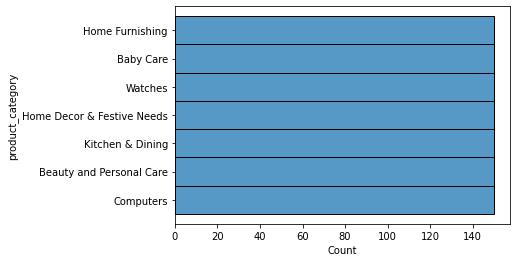

In [158]:
sns.histplot(data=data, y="product_category") # chaque catégorie possède le même nombre de produits

In [159]:
# code for product_category
data['product_category_code'] = data['product_category'].astype('category').cat.codes

In [160]:
l_cat_code_list = list(data['product_category_code'])
l_cat_code = np.array(l_cat_code_list)

## Nettoyage du texte

In [161]:
# exemple d'une description avant le nettoyage
data['description'][0]

'Key Features of Elegance Polyester Multicolor Abstract Eyelet Door Curtain Floral Curtain,Elegance Polyester Multicolor Abstract Eyelet Door Curtain (213 cm in Height, Pack of 2) Price: Rs. 899 This curtain enhances the look of the interiors.This curtain is made from 100% high quality polyester fabric.It features an eyelet style stitch with Metal Ring.It makes the room environment romantic and loving.This curtain is ant- wrinkle and anti shrinkage and have elegant apparance.Give your home a bright and modernistic appeal with these designs. The surreal attention is sure to steal hearts. These contemporary eyelet and valance curtains slide smoothly so when you draw them apart first thing in the morning to welcome the bright sun rays you want to wish good morning to the whole world and when you draw them close in the evening, you create the most special moments of joyous beauty given by the soothing prints. Bring home the elegant curtain that softly filters light in your room so that you

In [162]:
#!pip install clean-text # google colab
from cleantext import clean
data.description = data.description.apply(lambda x: clean(x, no_numbers=True, replace_with_number='')) # Delete numbers

In [163]:
# description après avoir supprimer les chiffres
data['description'][0]

'key features of elegance polyester multicolor abstract eyelet door curtain floral curtain,elegance polyester multicolor abstract eyelet door curtain ( cm in height, pack of ) price: rs. this curtain enhances the look of the interiors.this curtain is made from % high quality polyester fabric.it features an eyelet style stitch with metal ring.it makes the room environment romantic and loving.this curtain is ant- wrinkle and anti shrinkage and have elegant apparance.give your home a bright and modernistic appeal with these designs. the surreal attention is sure to steal hearts. these contemporary eyelet and valance curtains slide smoothly so when you draw them apart first thing in the morning to welcome the bright sun rays you want to wish good morning to the whole world and when you draw them close in the evening, you create the most special moments of joyous beauty given by the soothing prints. bring home the elegant curtain that softly filters light in your room so that you get the ri

In [164]:
# Tokenizer (decoupage des phrases)
from nltk import RegexpTokenizer
tokenizer = RegexpTokenizer(r'\w+')

data['clean_description'] = data['description'].apply(tokenizer.tokenize) 

In [167]:
# description après le tokenisation
data['clean_description'][0]

['key',
 'features',
 'of',
 'elegance',
 'polyester',
 'multicolor',
 'abstract',
 'eyelet',
 'door',
 'curtain',
 'floral',
 'curtain',
 'elegance',
 'polyester',
 'multicolor',
 'abstract',
 'eyelet',
 'door',
 'curtain',
 'cm',
 'in',
 'height',
 'pack',
 'of',
 'price',
 'rs',
 'this',
 'curtain',
 'enhances',
 'the',
 'look',
 'of',
 'the',
 'interiors',
 'this',
 'curtain',
 'is',
 'made',
 'from',
 'high',
 'quality',
 'polyester',
 'fabric',
 'it',
 'features',
 'an',
 'eyelet',
 'style',
 'stitch',
 'with',
 'metal',
 'ring',
 'it',
 'makes',
 'the',
 'room',
 'environment',
 'romantic',
 'and',
 'loving',
 'this',
 'curtain',
 'is',
 'ant',
 'wrinkle',
 'and',
 'anti',
 'shrinkage',
 'and',
 'have',
 'elegant',
 'apparance',
 'give',
 'your',
 'home',
 'a',
 'bright',
 'and',
 'modernistic',
 'appeal',
 'with',
 'these',
 'designs',
 'the',
 'surreal',
 'attention',
 'is',
 'sure',
 'to',
 'steal',
 'hearts',
 'these',
 'contemporary',
 'eyelet',
 'and',
 'valance',
 'curtai

In [168]:
# Nettoyage du text
# Stop words ("et", "à", "le"... en françai qui n'apportent peu de valeur informative)
# Stop words (pour l'anglais, "a", "an", "the", "of", etc.)
from nltk.corpus import stopwords
stop_w = list(set(stopwords.words('english'))) + ['[', ']', ',', '.', ':', '?', '(', ')']

def stop_word_filter_fct(list_words) :
    filtered_w = [w for w in list_words if not w in stop_w]
    filtered_w2 = [w for w in filtered_w if len(w) > 2]
    return filtered_w2

data['clean_description'] = data['clean_description'].apply(stop_word_filter_fct) 

In [170]:
#text after Stop words 
data['clean_description'][0]

['key',
 'features',
 'elegance',
 'polyester',
 'multicolor',
 'abstract',
 'eyelet',
 'door',
 'curtain',
 'floral',
 'curtain',
 'elegance',
 'polyester',
 'multicolor',
 'abstract',
 'eyelet',
 'door',
 'curtain',
 'height',
 'pack',
 'price',
 'curtain',
 'enhances',
 'look',
 'interiors',
 'curtain',
 'made',
 'high',
 'quality',
 'polyester',
 'fabric',
 'features',
 'eyelet',
 'style',
 'stitch',
 'metal',
 'ring',
 'makes',
 'room',
 'environment',
 'romantic',
 'loving',
 'curtain',
 'ant',
 'wrinkle',
 'anti',
 'shrinkage',
 'elegant',
 'apparance',
 'give',
 'home',
 'bright',
 'modernistic',
 'appeal',
 'designs',
 'surreal',
 'attention',
 'sure',
 'steal',
 'hearts',
 'contemporary',
 'eyelet',
 'valance',
 'curtains',
 'slide',
 'smoothly',
 'draw',
 'apart',
 'first',
 'thing',
 'morning',
 'welcome',
 'bright',
 'sun',
 'rays',
 'want',
 'wish',
 'good',
 'morning',
 'whole',
 'world',
 'draw',
 'close',
 'evening',
 'create',
 'special',
 'moments',
 'joyous',
 'beau

In [172]:
# lower case et alpha
def lower_start_fct(list_words) :
    lw = [w.lower() for w in list_words if (not w.startswith("@")) 
    #                                   and (not w.startswith("#"))
                                       and (not w.startswith("http"))]
    return lw


data['clean_description'] = data['clean_description'].apply(lower_start_fct) 

In [179]:
# Lemmatizer (base d'un mot, racinisation)
from nltk.stem import WordNetLemmatizer

def lemma_fct(list_words) :
    lemmatizer = WordNetLemmatizer()
    lem_w = [lemmatizer.lemmatize(w) for w in list_words]
    return lem_w

data['clean_description'] = data['clean_description'].apply(lemma_fct) 

In [180]:
# text after lemmatizer
data['clean_description'][0]

['key',
 'feature',
 'elegance',
 'polyester',
 'multicolor',
 'abstract',
 'eyelet',
 'door',
 'curtain',
 'floral',
 'curtain',
 'elegance',
 'polyester',
 'multicolor',
 'abstract',
 'eyelet',
 'door',
 'curtain',
 'height',
 'pack',
 'price',
 'curtain',
 'enhances',
 'look',
 'interior',
 'curtain',
 'made',
 'high',
 'quality',
 'polyester',
 'fabric',
 'feature',
 'eyelet',
 'style',
 'stitch',
 'metal',
 'ring',
 'make',
 'room',
 'environment',
 'romantic',
 'loving',
 'curtain',
 'ant',
 'wrinkle',
 'anti',
 'shrinkage',
 'elegant',
 'apparance',
 'give',
 'home',
 'bright',
 'modernistic',
 'appeal',
 'design',
 'surreal',
 'attention',
 'sure',
 'steal',
 'heart',
 'contemporary',
 'eyelet',
 'valance',
 'curtain',
 'slide',
 'smoothly',
 'draw',
 'apart',
 'first',
 'thing',
 'morning',
 'welcome',
 'bright',
 'sun',
 'ray',
 'want',
 'wish',
 'good',
 'morning',
 'whole',
 'world',
 'draw',
 'close',
 'evening',
 'create',
 'special',
 'moment',
 'joyous',
 'beauty',
 'gi

In [37]:
# Fonction de préparation du texte pour le bag of words avec lemmatization
def transform_bow_lem_fct(desc_text) :
    sw = stop_word_filter_fct(desc_text)
    lw = lower_start_fct(sw)
    lem_w = lemma_fct(lw)    
    transf_desc_text = ' '.join(lem_w)
    return transf_desc_text

In [38]:
# Function application for my dataset 
#nltk.download('wordnet')
data['clean_description'] = data['clean_description'].apply(transform_bow_lem_fct) 


In [39]:
# text after all of the text traitement
data['clean_description'][0]

'key feature elegance polyester multicolor abstract eyelet door curtain floral curtain elegance polyester multicolor abstract eyelet door curtain height pack price curtain enhances look interior curtain made high quality polyester fabric feature eyelet style stitch metal ring make room environment romantic loving curtain ant wrinkle anti shrinkage elegant apparance give home bright modernistic appeal design surreal attention sure steal heart contemporary eyelet valance curtain slide smoothly draw apart first thing morning welcome bright sun ray want wish good morning whole world draw close evening create special moment joyous beauty given soothing print bring home elegant curtain softly filter light room get right amount sunlight specification elegance polyester multicolor abstract eyelet door curtain height pack general brand elegance designed door type eyelet model name abstract polyester door curtain set model duster25 color multicolor dimension length box number content sale packag

In [41]:
data_description_cleaned = data.loc[:,'clean_description']

# Bag of word - CountVectorizer - Tf-idf

In [ ]:
# creation of bag of words (CountVectorizer and Tf-idf) for test vectors
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

cvect = CountVectorizer(stop_words='english', max_df=0.95, min_df=1)
ctf = TfidfVectorizer(stop_words='english', max_df=0.95, min_df=1)

feat = 'sentence_bow_lem'
cv_fit = cvect.fit(data_description_cleaned)
ctf_fit = ctf.fit(data_description_cleaned)

cv_transform = cvect.transform(data_description_cleaned)  
ctf_transform = ctf.transform(data_description_cleaned)

### BOW-Tf-idf-dimention reduction(t-SNE)

In [263]:
import time

def ARI_fct(features, l_cat_code) :
    """
    Calcul Tsne, détermination des clusters et calcul ARI entre vrais catégorie et n° de clusters
    """
    time1 = time.time()
    num_labels=7
    tsne = manifold.TSNE(n_components=2, perplexity=30, n_iter=2000, 
                                 init='random', learning_rate=400, random_state=12)
    X_tsne = tsne.fit_transform(features)

    # Détermination des clusters à partir des données après Tsne 

    cls = cluster.KMeans(n_clusters=7, n_init=100, random_state=42)
    cls.fit(X_tsne)
    ARI = np.round(metrics.adjusted_rand_score(l_cat_code, cls.labels_),4)
    time2 = np.round(time.time() - time1,0)
    print("ARI : ", ARI, "time : ", time2)
    
    return ARI, X_tsne, cls.labels_


In [264]:
# visualisation du Tsne selon les vraies catégories et selon les clusters
def TSNE_visu_fct(X_tsne, l_cat_code, labels, ARI) :
    fig = plt.figure(figsize=(15,6))
    
    ax = fig.add_subplot(121)
    scatter = ax.scatter(X_tsne[:,0],X_tsne[:,1], c=l_cat_code, cmap='Set1')
    ax.legend(handles=scatter.legend_elements()[0], labels= sorted(l_category), loc="best", title="Categorie")
    plt.title('Représentation des produits par catégories réelles')
    
    ax = fig.add_subplot(122)
    scatter = ax.scatter(X_tsne[:,0],X_tsne[:,1], c=labels, cmap='Set1')
    ax.legend(handles=scatter.legend_elements()[0], labels=set(labels), loc="best", title="Clusters")
    plt.title('Représentation des prduits par clusters')
    
    plt.show()
    print("ARI : ", ARI)

In [ ]:
# ARI for CountVectorizer
print("CountVectorizer : ")
print("-----------------")
ARI_cv, X_tsne_cv, labels_cv = ARI_fct(cv_transform, l_cat_code)

CountVectorizer : 
-----------------
ARI :  0.456 time :  16.0


In [ ]:
# ARI dor Tf-idf
print("Tf-idf : ")
print("--------")
ARI_ctf, X_tsne_ctf, labels_ctf = ARI_fct(ctf_transform, l_cat_code)

Tf-idf : 
--------
ARI :  0.5691 time :  14.0


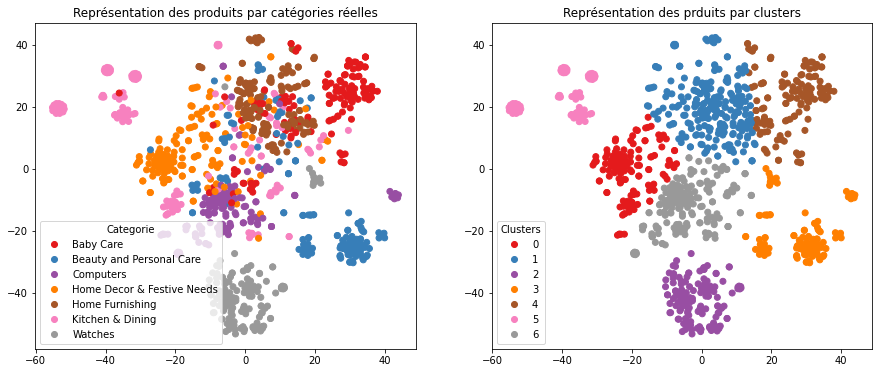

ARI :  0.456


In [ ]:
TSNE_visu_fct(X_tsne_cv, l_cat_code, labels_cv, ARI_cv)

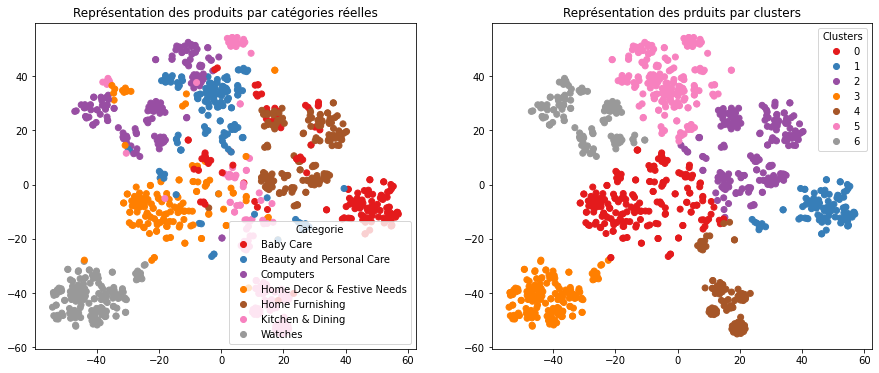

ARI :  0.5691


In [ ]:
TSNE_visu_fct(X_tsne_ctf, l_cat_code, labels_ctf, ARI_ctf)

##### Constat : <b>ARI pour Tf-idf présente le meilleur résultat parmi les autres</b>


### Entrainer avec random forest pour classifier les texte avec Tf-idf

In [ ]:
# import
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import scale
from sklearn import preprocessing

In [ ]:
product_category_code = data.loc[:, "product_category_code"]

### Séparation du trainning dataset et du testing dataset


In [ ]:
X = ctf_transform
y = data.loc[:, "product_category_code"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

### GridSearchCV pour trouver les meilleurs hyparamètres

In [ ]:
bootstrap_range = [True, False]
criterion = ['gini', 'entropy']
n_estimators_range = [100, 150, 200]
max_depth_range = [25, 50, 75]
min_samples_split_range = [2, 5, 10]
min_samples_leaf_range = [1,2,5,10]
max_features_range  = ['sqrt', 'log2']

param_rfc = {'max_features' : max_features_range,
             'max_depth': max_depth_range,
             'min_samples_split': min_samples_split_range,
             'min_samples_leaf': min_samples_leaf_range,
             'n_estimators' : n_estimators_range,
             'criterion' : criterion
             }


In [ ]:
score = 'accuracy'

grid_pred = GridSearchCV(RandomForestClassifier(random_state=42),
        param_grid=param_rfc,
        cv=5,
        scoring=score)
                                    
grid_pred.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [25, 50, 75],
                         'max_features': ['sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 5, 10],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 150, 200]},
             scoring='accuracy')

### Calcul des performances réelles sur la base de test

In [ ]:
# Entrainer les testing dataset avec les meilleur hyperparamètres trouvé dans la cellule précédente
best_grid = grid_pred.best_estimator_
y_test_pred_cv = best_grid.predict(X_test)
grid_pred.best_params_

{'criterion': 'gini',
 'max_depth': 50,
 'max_features': 'log2',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 150}

In [ ]:
# Précision 
accuracy_cv = accuracy_score(y_test, y_test_pred_cv)

In [ ]:
accuracy_cv

0.9429657794676806

In [ ]:
# Entrainer les training dataset avec les meilleur hyperparamètres pour savoir si l'entrainement est overfit
y_train_pred_cv = best_grid.predict(X_train)
accuracy_cv_train = accuracy_score( y_train, y_train_pred_cv)

In [ ]:
accuracy_cv_train

1.0

##### Constat : **Apprentissage avec random-forest montre une précision élevée (0.942)**

# Word2Vec

In [ ]:
# import
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras import backend as K

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import metrics as kmetrics
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
import gensim

## Création du modèle Word2Vec

In [ ]:
w2v_size=300 # vector size
w2v_window=10 # words surronding
w2v_min_count=1
w2v_epochs=100
maxlen = 50 # adapt to length of sentences
sentences = data_description_cleaned.to_list()
sentences = [gensim.utils.simple_preprocess(text) for text in sentences]

In [ ]:
# Création et entraînement du modèle Word2Vec
print("Build & train Word2Vec model ...")
w2v_model = gensim.models.Word2Vec(min_count=w2v_min_count, window=w2v_window,
                                  vector_size=w2v_size,
                                  seed=42,
                                  workers=1)
w2v_model.build_vocab(sentences)
w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=w2v_epochs)
model_vectors = w2v_model.wv
w2v_words = model_vectors.index_to_key
print("Vocabulary size: %i" % len(w2v_words))
print("Word2Vec trained")

Build & train Word2Vec model ...
Vocabulary size: 4614
Word2Vec trained


In [ ]:
# Préparation des sentences (tokenization)
print("Fit Tokenizer ...")
tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)
x_sentences = pad_sequences(tokenizer.texts_to_sequences(sentences),
                                                     maxlen=maxlen,
                                                     padding='post') 
                                                   
num_words = len(tokenizer.word_index) + 1
print("Number of unique words: %i" % num_words)

Fit Tokenizer ...
Number of unique words: 4615


## Création de la matrice d'embedding

In [ ]:
# Création de la matrice d'embedding
print("Create Embedding matrix ...")
w2v_size = 300
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1
embedding_matrix = np.zeros((vocab_size, w2v_size))
i=0
j=0
    
for word, idx in word_index.items():
    i +=1
    if word in w2v_words:
        j +=1
        embedding_vector = model_vectors[word]
        if embedding_vector is not None:
            embedding_matrix[idx] = model_vectors[word]
            
word_rate = np.round(j/i,4)
print("Word embedding rate : ", word_rate)
print("Embedding matrix: %s" % str(embedding_matrix.shape))

Create Embedding matrix ...
Word embedding rate :  1.0
Embedding matrix: (4615, 300)


## Création du modèle d'embedding

In [ ]:
# Création du modèle
input = Input(shape=(len(x_sentences), maxlen),dtype='float64')
word_input = Input(shape=(maxlen,), dtype='float64')  
word_embedding = Embedding(input_dim=vocab_size,
                         output_dim=w2v_size,
                         weights=[embedding_matrix],
                         input_length=maxlen)(word_input)
word_vec = GlobalAveragePooling1D()(word_embedding)  
embed_model = Model([word_input],word_vec)

embed_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 50)]              0         
                                                                 
 embedding (Embedding)       (None, 50, 300)           1384500   
                                                                 
 global_average_pooling1d (G  (None, 300)              0         
 lobalAveragePooling1D)                                          
                                                                 
Total params: 1,384,500
Trainable params: 1,384,500
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Exécution du modèle
embeddings = embed_model.predict(x_sentences)
embeddings.shape

33/33 [==============================] - 0s 2ms/step


(1050, 300)

In [ ]:
ARI_w2v, X_tsne_w2v, labels_w2v = ARI_fct(embeddings,l_cat_code)

ARI :  0.3582 time :  13.0


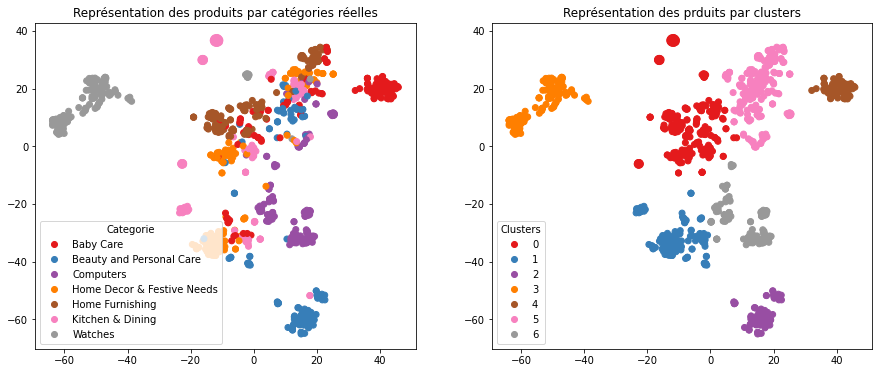

ARI :  0.3582


In [ ]:
TSNE_visu_fct(X_tsne_w2v, l_cat_code, labels_w2v, ARI_w2v)

## Random forest classifier (word2vec)

In [ ]:
product_category_code = data.loc[:, "product_category_code"]

X_w2v = embeddings
y_w2v = product_category_code
#std_scale = preprocessing.StandardScaler().fit(X)
#X_std = std_scale.transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_w2v, y_w2v, test_size=0.25, random_state=42)

In [ ]:
bootstrap_range = [True, False]
criterion = ['gini', 'entropy']
n_estimators_range = [100, 150, 200]
max_depth_range = [25, 50, 75]
min_samples_split_range = [2, 5, 10]
min_samples_leaf_range = [1,2,5,10]
max_features_range  = ['sqrt', 'log2']

param_rfc = {'max_features' : max_features_range,
             'max_depth': max_depth_range,
             'min_samples_split': min_samples_split_range,
             'min_samples_leaf': min_samples_leaf_range,
             'n_estimators' : n_estimators_range,
             'criterion' : criterion
             }

score = 'accuracy'

grid_pred = GridSearchCV(RandomForestClassifier(random_state=42),
        param_grid=param_rfc,
        cv=5,
        scoring=score)
                                    
grid_pred.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [25, 50, 75],
                         'max_features': ['sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 5, 10],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 150, 200]},
             scoring='accuracy')

In [ ]:
best_grid_w2v = grid_pred.best_estimator_
y_test_pred_cv_w2v = best_grid_w2v.predict(X_test)
grid_pred.best_params_
accuracy_cv_w2v = accuracy_score(y_test, y_test_pred_cv)
accuracy_cv_w2v

0.9391634980988594

# BERT

In [44]:
# Fonction de préparation du texte pour le Deep learning (USE et BERT)
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize

def tokenizer_fct(sentence) :
    # print(sentence)
    sentence_clean = sentence.replace('-', ' ').replace('+', ' ').replace('/', ' ').replace('#', ' ')
    word_tokens = word_tokenize(sentence_clean)
    return word_tokens
    
def transform_dl_fct(desc_text) :
    word_tokens = tokenizer_fct(desc_text)
    lw = lower_start_fct(word_tokens)  
    transf_desc_text = ' '.join(lw)
    return transf_desc_text

In [45]:
data2 = data.copy()

In [46]:
data2['description_bert_use'] = data2['description'].apply(transform_dl_fct)

In [47]:
description_bert_use2 = data2.loc[:, 'description_bert_use']

In [48]:
l_cat_code2_list = list(data2['product_category_code'])
l_cat_code2 = np.array(l_cat_code2_list)

In [270]:
import tensorflow as tf
# import tensorflow_hub as hub
import tensorflow.keras
from tensorflow.keras import backend as K

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import metrics as kmetrics
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model

# Bert
import os
import transformers
from transformers import *

os.environ["TF_KERAS"]='1'

In [271]:
# Fonction de préparation des sentences
def bert_inp_fct(sentences, bert_tokenizer, max_length) :
    input_ids=[]
    token_type_ids = []
    attention_mask=[]
    bert_inp_tot = []

    for sent in sentences:
        bert_inp = bert_tokenizer.encode_plus(sent,
                                              add_special_tokens = True,
                                              max_length = max_length,
                                              padding='max_length',
                                              return_attention_mask = True, 
                                              return_token_type_ids=True,
                                              truncation=True,
                                              return_tensors="tf")
    
        input_ids.append(bert_inp['input_ids'][0])
        token_type_ids.append(bert_inp['token_type_ids'][0])
        attention_mask.append(bert_inp['attention_mask'][0])
        bert_inp_tot.append((bert_inp['input_ids'][0], 
                             bert_inp['token_type_ids'][0], 
                             bert_inp['attention_mask'][0]))

    input_ids = np.asarray(input_ids)
    token_type_ids = np.asarray(token_type_ids)
    attention_mask = np.array(attention_mask)
    
    return input_ids, token_type_ids, attention_mask, bert_inp_tot
    

# Fonction de création des features
def feature_BERT_fct(model, model_type, sentences, max_length, b_size, mode='HF') :
    batch_size = b_size
    batch_size_pred = b_size
    bert_tokenizer = AutoTokenizer.from_pretrained(model_type)
    time1 = time.time()

    for step in range(len(sentences)//batch_size) :
        idx = step*batch_size
        input_ids, token_type_ids, attention_mask, bert_inp_tot = bert_inp_fct(sentences[idx:idx+batch_size], 
                                                                      bert_tokenizer, max_length)
        
        if mode=='HF' :    # Bert HuggingFace
            outputs = model.predict([input_ids, attention_mask, token_type_ids], batch_size=batch_size_pred)
            last_hidden_states = outputs.last_hidden_state

        if mode=='TFhub' : # Bert Tensorflow Hub
            text_preprocessed = {"input_word_ids" : input_ids, 
                                 "input_mask" : attention_mask, 
                                 "input_type_ids" : token_type_ids}
            outputs = model(text_preprocessed)
            last_hidden_states = outputs['sequence_output']
             
        if step ==0 :
            last_hidden_states_tot = last_hidden_states
            last_hidden_states_tot_0 = last_hidden_states
        else :
            last_hidden_states_tot = np.concatenate((last_hidden_states_tot,last_hidden_states))
    
    features_bert = np.array(last_hidden_states_tot).mean(axis=1)
    
    time2 = np.round(time.time() - time1,0)
    print("temps traitement : ", time2)
     
    return features_bert, last_hidden_states_tot

## BERT HuggingFace

### 'bert-base-uncased'

In [272]:
max_length = 64 # 
batch_size = 10 # 
model_type = 'bert-base-uncased'
model = TFAutoModel.from_pretrained(model_type)
sentences_bert = description_bert_use2.to_list()


In [273]:
# Création des features
features_bert, last_hidden_states_tot = feature_BERT_fct(model=model, model_type=model_type, sentences=sentences_bert, 
                                                         max_length=max_length, b_size=batch_size, mode='HF')

1/1 [==============================] - 2s 2s/step
temps traitement :  364.0


In [274]:
ARI_bert, X_tsne_bert, labels_bert = ARI_fct(features_bert, l_cat_code2)

ARI :  0.3121 time :  17.0


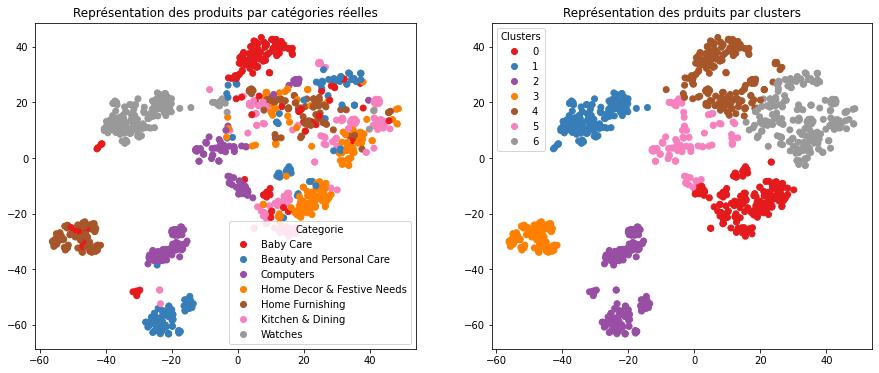

ARI :  0.3121


In [275]:
TSNE_visu_fct(X_tsne_bert, l_cat_code2, labels_bert, ARI_bert)

### Modèle : 'cardiffnlp/twitter-roberta-base-sentiment'
* Modèle pré-entraîné sur des tweets pour l'analyse de sentiment = particulièrement adapté au contexte

In [276]:
max_length = 64
batch_size = 10
model_type = 'cardiffnlp/twitter-roberta-base-sentiment'
model = TFAutoModel.from_pretrained(model_type)
sentences_bert2 = description_bert_use2.to_list()

In [277]:
features_bert2, last_hidden_states_tot = feature_BERT_fct(model = model , model_type = model_type, sentences = sentences_bert2, 
                                                         max_length = max_length, b_size = batch_size, mode='HF')

1/1 [==============================] - 3s 3s/step
temps traitement :  389.0


In [278]:
ARI_bert2, X_tsne_bert2, labels_bert2 = ARI_fct(features_bert2, l_cat_code2)

ARI :  0.2154 time :  17.0


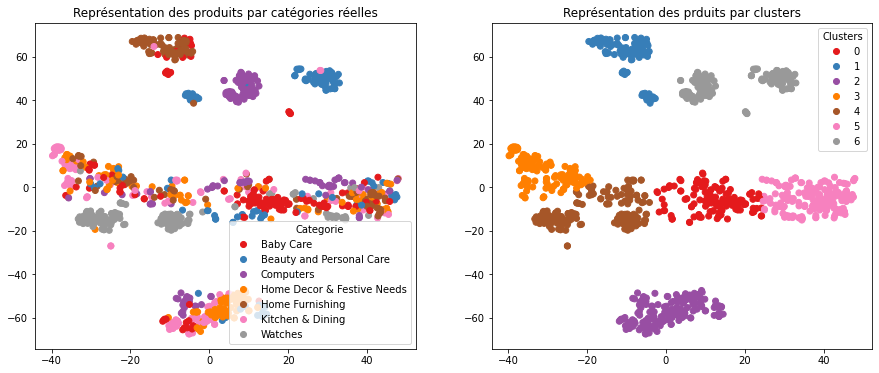

ARI :  0.2154


In [279]:
TSNE_visu_fct(X_tsne_bert2, l_cat_code2, labels_bert2, ARI_bert2)

# USE - Universal Sentence Encoder

In [ ]:
# Chargez le module TF Hub d'Universal Sentence Encoder
import tensorflow_hub as hub

embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

In [ ]:
def feature_USE_fct(sentences, b_size) :
    batch_size = b_size
    time1 = time.time()

    for step in range(len(sentences)//batch_size) :
        idx = step*batch_size
        feat = embed(sentences[idx:idx+batch_size])

        if step ==0 :
            features = feat
        else :
            features = np.concatenate((features,feat))

    time2 = np.round(time.time() - time1,0)
    return features

In [ ]:
batch_size_use = 10
sentences_use = description_bert_use2.to_list()

In [ ]:
features_USE = feature_USE_fct(sentences_use, batch_size_use)

In [ ]:
ARI_use, X_tsne_use, labels_use = ARI_fct(features_USE, l_cat_code2)

ARI :  0.4315 time :  14.0


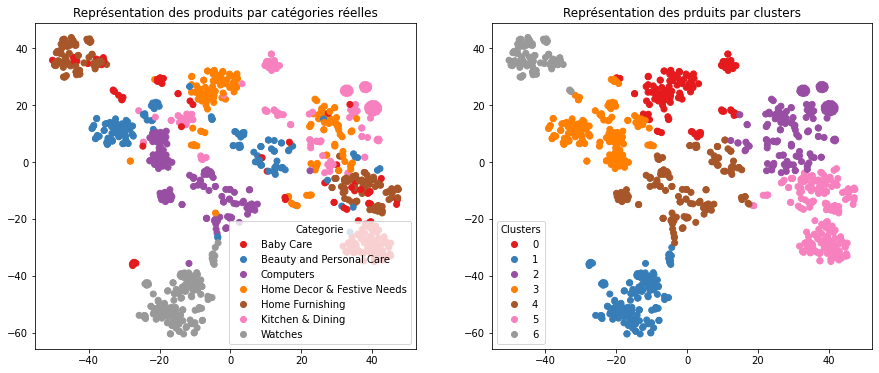

ARI :  0.4315


In [ ]:
TSNE_visu_fct(X_tsne_use, l_cat_code2, labels_use, ARI_use)

# Prétaitement des images et clustering des images


### Load, read original images and transform them into denoised images

In [19]:
image_folder = "Flipkart/Images/"
denoised_image_folder = "Flipkart/images_denoising/"

list_photos = [file for file in listdir(image_folder) if '.jpg' in file]

for image_filename in list_photos:
    img = cv2.imread(image_folder + image_filename)
    denoised_img = cv2.fastNlMeansDenoisingColored(img, None,10,10,7,21)
    cv2.imwrite(denoised_image_folder + image_filename, denoised_img)

original image


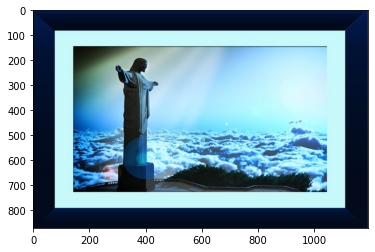

processed image


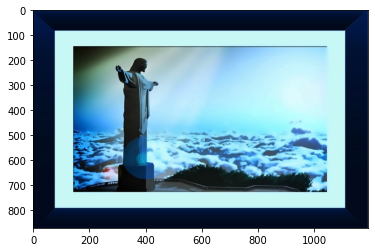

In [79]:
list_photos = [file for file in listdir(denoised_image_folder) if '.jpg' in file]
random_image = random.choice(list_photos)

print("original image")
plt.imshow(cv2.imread(image_folder + random_image), aspect='auto')
plt.show()

print("processed image")
plt.imshow(cv2.imread(denoised_image_folder + random_image), aspect='auto')
plt.show()

### We will then use the denoised images for the remaining exprimentations

#### Affichage d'exemples d'images par label

Home Furnishing


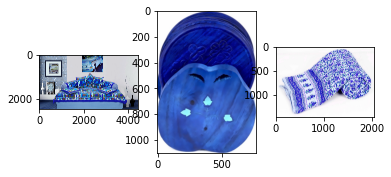

Baby Care


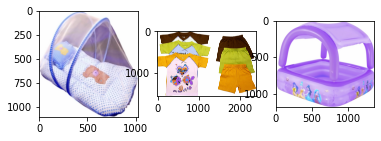

Watches


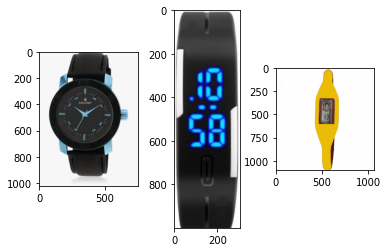

Home Decor & Festive Needs


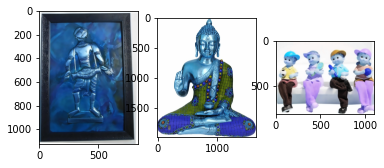

Kitchen & Dining


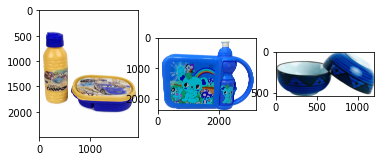

Beauty and Personal Care


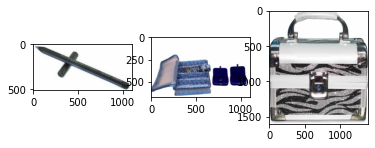

Computers


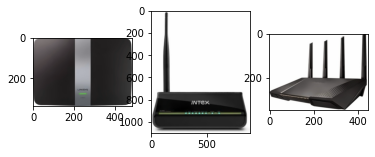

In [81]:
def list_fct(name):
    list_image_name = data2.loc[data2['product_category']==name].image.to_list()
    return list_image_name

list_labels = data2["product_category"].unique()

# show 3 imgaes belong to same categorie
for name in list_labels :
    print(name)
    for i in range(3):
        plt.subplot(130 + 1 + i)
        filename = denoised_image_folder + list_fct(name)[i+10]
        image = cv2.imread(filename)
        plt.imshow(image)
    plt.show()

## Détermination et affichage des descripteurs SIFT

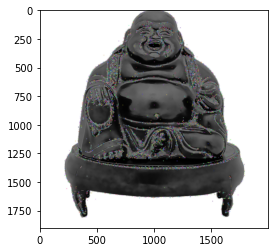

Descripteurs :  (5625, 128)
[[ 99.  41.   0. ...   0.   0.   0.]
 [  0.   0.   0. ...   0.   0.   1.]
 [ 84. 132.  20. ...   0.   0.   2.]
 ...
 [ 71.  19.   0. ...   0.   0.   0.]
 [ 51.   1.   0. ...   0.   0.   0.]
 [ 78.  12.   0. ...   0.   0.   0.]]


In [83]:
"""exemple d'affichage des descripteurs d'un image"""
sift = cv2.SIFT_create() #cv2.xfeatures2d.SIFT_create() is depracated
image = cv2.imread(denoised_image_folder + list_photos[3], 0) # convert in gray
image = cv2.equalizeHist(image)   # equalize image histogram
kp, des = sift.detectAndCompute(image, None)
img = cv2.drawKeypoints(image, kp, image)
plt.imshow(img)
plt.show()
print("Descripteurs : ", des.shape)
print(des)

## Prétaitement des images par SIFT

### Créations des descripteurs pour chaque image


In [84]:
# identification of key points and associated descriptors
from cmath import isnan
import time

sift_keypoints = []
temps1 = time.time()
sift = cv2.SIFT_create(500)

for image_num in range(len(list_photos)):
    image = cv2.imread(denoised_image_folder + list_photos[image_num], 0)
    res = cv2.equalizeHist(image)   # equalize image histogram
    kp, des = sift.detectAndCompute(res, None)
    sift_keypoints.append(des)

sift_keypoints_by_img = np.asarray(sift_keypoints)
sift_keypoints_all    = np.concatenate(sift_keypoints_by_img, axis=0)

print("Nombre de descripteurs : ", sift_keypoints_all.shape)

duration1=time.time() - temps1
print("temps de traitement SIFT descriptor : ", "%15.2f" % duration1, "secondes")

/Users/yixuanzhao/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


Nombre de descripteurs :  (471490, 128)
temps de traitement SIFT descriptor :           770.33 secondes


## Création des clusters de descripteurs
* Utilisation de MiniBatchKMeans pour obtenir des temps de traitement raisonnables

In [85]:
# Determination number of clusters
temps1 = time.time()

# square root of the descriptors number
k = int(round(np.sqrt(len(sift_keypoints_all)),0))
print("Nombre de clusters estimés : ", k)
print("Création de",k, "clusters de descripteurs ...")

Nombre de clusters estimés :  687
Création de 687 clusters de descripteurs ...


In [86]:
# Clustering (changer le nombre de cluster)
kmeans = cluster.MiniBatchKMeans(n_clusters=256, init_size=3*k, random_state=42)
kmeans.fit(sift_keypoints_all)

duration1=time.time() - temps1
print("temps de traitement kmeans : ", "%15.2f" % duration1, "secondes")

temps de traitement kmeans :           101.98 secondes


## Création des features des images


In [87]:
# Creation of histograms (features)
temps1 = time.time()

def build_histogram(kmeans, des, image_num):
    res = kmeans.predict(des)
    hist = np.zeros(len(kmeans.cluster_centers_))
    nb_des=len(des)
    if nb_des==0 : print("problème histogramme image  : ", image_num)
    for i in res:
        hist[i] += 1.0/nb_des
    return hist


# Creation of a matrix of histograms
hist_vectors=[]

for i, image_desc in enumerate(sift_keypoints_by_img) : 
    hist = build_histogram(kmeans, image_desc, i) #calculates the histogram
    hist_vectors.append(hist) #histogram is the feature vector

im_features = np.asarray(hist_vectors)

duration1 = time.time() - temps1
print("temps de création histogrammes : ", "%15.2f" % duration1, "secondes")

temps de création histogrammes :             9.31 secondes


In [88]:
im_features.shape

(1050, 256)

# PCA

In [89]:
# PCA, dimensionality reduction and time reduction
from sklearn import manifold, decomposition

print("Dimensions dataset avant réduction PCA : ", im_features.shape)

"""
If 0 < n_components < 1 and svd_solver == 'full', 
select the number of components such that the amount of variance that needs to be explained is greater than the percentage specified by n_components
"""

pca = decomposition.PCA(n_components=0.80, svd_solver = "full")

feat_pca= pca.fit_transform(im_features)

print("Dimensions dataset après réduction PCA : ", feat_pca.shape)

Dimensions dataset avant réduction PCA :  (1050, 256)
Dimensions dataset après réduction PCA :  (1050, 43)



### Réduction de dimension en 2 composantes T-SNE pour affichage en 2D des images

In [90]:
from sklearn import manifold, decomposition

tsne = manifold.TSNE(n_components=2, perplexity=30, 
                     n_iter=2000, init='random', random_state=14)
X_tsne = tsne.fit_transform(feat_pca)

df_tsne = pd.DataFrame(X_tsne[:,0:2], columns=['tsne1', 'tsne2'])
df_tsne["class"] = data2["product_category"]
print(df_tsne.shape)


/Users/yixuanzhao/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


(1050, 3)


In [91]:
# code for class in dt_tsne
df_tsne['class_code'] = data2['product_category_code']

l_class_code = list(df_tsne['class_code'])
l_class_code = np.array(l_class_code)

In [92]:
df_tsne

,tsne1,tsne2,class,class_code
0,-11.766479,27.268120,Home Furnishing,4
1,22.726500,24.224510,Baby Care,0
2,4.217316,-5.119717,Baby Care,0
3,-8.646867,-13.232720,Home Furnishing,4
4,11.140133,4.614350,Home Furnishing,4
...,...,...,...,...
1045,-41.410110,-19.099659,Baby Care,0
1046,4.385831,-3.395634,Baby Care,0
1047,37.577065,13.995661,Baby Care,0
1048,-13.692489,-12.591291,Baby Care,0


## Analyse visuelle : affichage T-SNE selon catégories d'images

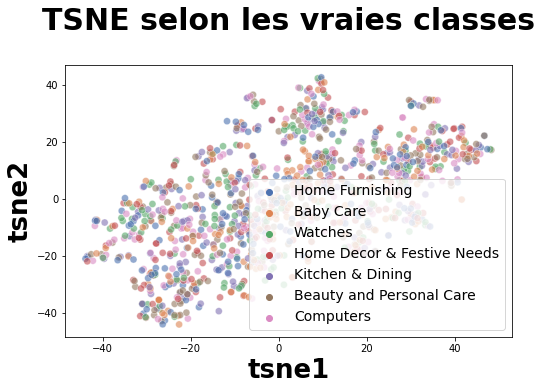

In [93]:
plt.figure(figsize=(8,5))
sns.scatterplot(
    x="tsne1", y="tsne2", hue="class", data=df_tsne, legend="brief",
    palette="deep", s=50, alpha=0.6)

plt.title('TSNE selon les vraies classes', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 14}) 

plt.show()

## Analyse mesures : similarité entre catégories et clusters
###  Création de clusters à partir du T-SNE

In [94]:
# k-means
from sklearn import cluster, metrics

cls = cluster.KMeans(n_clusters=7, random_state=6)
cls.fit(feat_pca)

df_tsne["cluster"] = cls.labels_
print(df_tsne.shape)


(1050, 5)


In [95]:
df_tsne

,tsne1,tsne2,class,class_code,cluster
0,-11.766479,27.268120,Home Furnishing,4,3
1,22.726500,24.224510,Baby Care,0,3
2,4.217316,-5.119717,Baby Care,0,3
3,-8.646867,-13.232720,Home Furnishing,4,3
4,11.140133,4.614350,Home Furnishing,4,3
...,...,...,...,...,...
1045,-41.410110,-19.099659,Baby Care,0,2
1046,4.385831,-3.395634,Baby Care,0,3
1047,37.577065,13.995661,Baby Care,0,3
1048,-13.692489,-12.591291,Baby Care,0,2


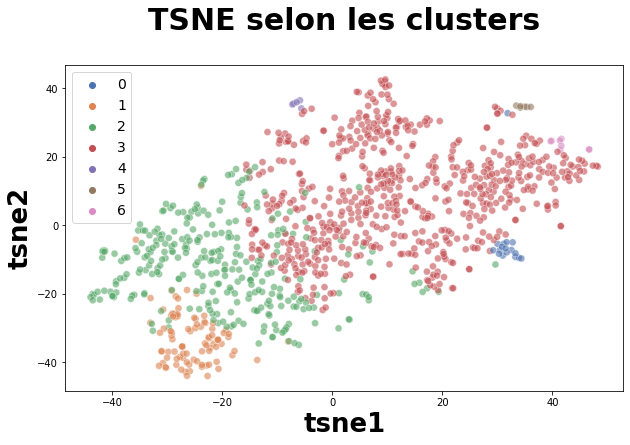

ARI :  -0.0003959550580931855


In [96]:
import numpy
plt.figure(figsize=(10,6))
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="cluster",
    palette="deep", s=50, alpha=0.6,
    data=df_tsne,
    legend="brief")

plt.title('TSNE selon les clusters', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 14}) 

plt.show()

labels = df_tsne['class_code'].values
print("ARI : ", metrics.adjusted_rand_score(labels, df_tsne["cluster"].values))



##### Constat : **ARI = -0.00039 est très faible, du coup, la méthode SIFT n'est pas très efficace dans notre cas. J'ai ensuite essayé le CNN avec les réseau neuronne pré-entrainé pour l'extraction des features**

### Analyse par classes

In [ ]:
conf_mat = metrics.confusion_matrix(labels, cls.labels_)
print(conf_mat)

[[12 22 18 32 21 19 26]
 [21 24 25 25 24 10 21]
 [18 26 21 21 19 16 29]
 [19 27 18 31 22 11 22]
 [15 26 13 25 26 22 23]
 [15 31 25 16 25 16 22]
 [23 20 18 20 22 20 27]]


In [ ]:
def conf_mat_transform(y_true,y_pred) :
    conf_mat = metrics.confusion_matrix(y_true,y_pred)
    
    corresp = [6,5,4, 3, 1, 2, 0]
    print ("Correspondance des clusters : ", corresp)

    labels = pd.Series(y_true, name="y_true").to_frame()
    labels['y_pred'] = y_pred
    labels['y_pred_transform'] = labels['y_pred'].apply(lambda x : corresp[x]) 
    
    return labels['y_pred_transform']

cls_labels_transform = conf_mat_transform(labels, cls.labels_)
conf_mat = metrics.confusion_matrix(labels, cls_labels_transform)
print(conf_mat)
print()
print(metrics.classification_report(labels, cls_labels_transform))

Correspondance des clusters :  [6, 5, 4, 3, 1, 2, 0]
[[26 21 19 32 18 22 12]
 [21 24 10 25 25 24 21]
 [29 19 16 21 21 26 18]
 [22 22 11 31 18 27 19]
 [23 26 22 25 13 26 15]
 [22 25 16 16 25 31 15]
 [27 22 20 20 18 20 23]]

              precision    recall  f1-score   support

           0       0.15      0.17      0.16       150
           1       0.15      0.16      0.16       150
           2       0.14      0.11      0.12       150
           3       0.18      0.21      0.19       150
           4       0.09      0.09      0.09       150
           5       0.18      0.21      0.19       150
           6       0.19      0.15      0.17       150

    accuracy                           0.16      1050
   macro avg       0.15      0.16      0.15      1050
weighted avg       0.15      0.16      0.15      1050



<AxesSubplot:>

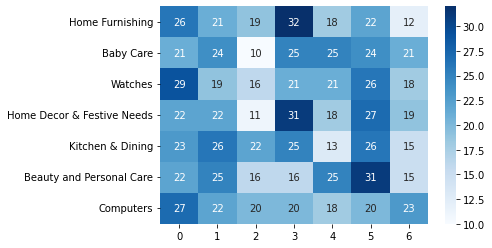

In [ ]:
df_cm = pd.DataFrame(conf_mat, index = [label for label in list_labels],
                  columns = [i for i in "0123456"])
plt.figure(figsize = (6,4))
sns.heatmap(df_cm, annot=True, cmap="Blues", fmt='g')

# CNN transfer learning
### VGG_16

In [97]:
# import 
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from matplotlib.image import imread
from keras.layers import Dense, Flatten
from keras import Model
import cv2
import glob
import tensorflow as tf

from os import listdir

In [98]:
# import model
vgg_model = VGG16(include_top=False, weights='imagenet', pooling='avg')

2022-10-23 10:24:26.341135: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [99]:
# Feature extraction
features_list = []
images_list = []

for im in list_photos:
    im_arr = cv2.imread(denoised_image_folder + im)
    img = cv2.resize(im_arr, (224, 224)).reshape(-1, 224, 224, 3)
    im_feat = vgg_model(img).numpy()[0]
    features_list.append((im, im_feat))

In [100]:
# Get categorie labels
list_categories = [data2[data2['image']==photo].product_category.item() for photo in list_photos]
list_cate_code = [data2[data2['image']==photo].product_category_code.item() for photo in list_photos]


In [101]:
# T-sne dimension reduction for vizualisation
from sklearn import manifold
import numpy as np

features = [feat[1] for feat in features_list]
tsne = manifold.TSNE(n_components=2, init='pca', random_state=0)
X_tsne = tsne.fit_transform(np.stack(features))

/Users/yixuanzhao/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/Users/yixuanzhao/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


(1050, 3)


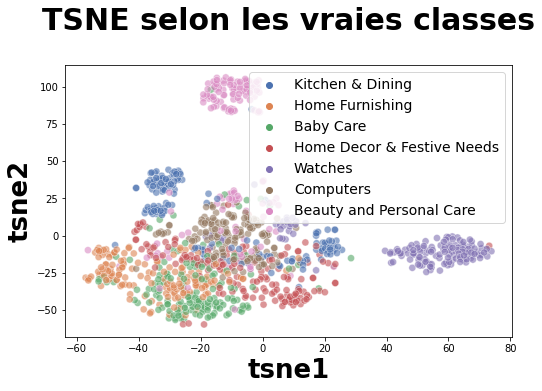

In [102]:
df_tsne = pd.DataFrame(X_tsne[:,0:2], columns=['tsne1', 'tsne2'])
df_tsne["class"] = list_categories
print(df_tsne.shape)
plt.figure(figsize=(8,5))
sns.scatterplot(
    x="tsne1", y="tsne2", hue="class", data=df_tsne, legend="brief",
    palette="deep", s=50, alpha=0.6)

plt.title('TSNE selon les vraies classes', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 14}) 

plt.show()

In [103]:
#  K-means clustering
from sklearn import cluster, metrics

cls = cluster.KMeans(n_clusters=7, random_state=42)
cls.fit(X_tsne)

df_tsne["cluster"] = cls.labels_
print(df_tsne.shape)

(1050, 4)


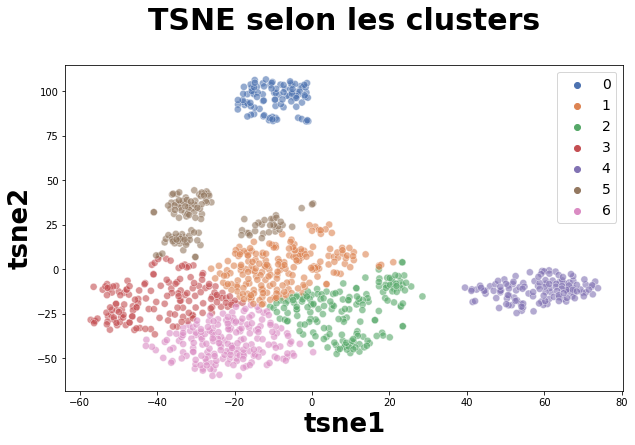

ARI :  0.3782452852075278


In [104]:
# K-means clustering and ARI
plt.figure(figsize=(10,6))
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="cluster",
    palette="deep", s=50, alpha=0.6,
    data=df_tsne,
    legend="brief")

plt.title('TSNE selon les clusters', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 14}) 

plt.show()

labels = list_cate_code
print("ARI : ", metrics.adjusted_rand_score(labels, cls.labels_))


## Apprentissage de classification avec VGG-16 transfer learning
 

In [131]:
# fonction for separation of images
import shutil

def create_folders(train=0.8, val=0.1, test=0.1):
    src = 'Flipkart/images_denoising'
    os.mkdir('train_images_denoising')
    os.mkdir('val_images_denoising')
    os.mkdir('test_images_denoising')

    for category_name in data2.product_category.unique():
        os.mkdir('train_images_denoising/' + category_name)
        os.mkdir('val_images_denoising/' + category_name)
        os.mkdir('test_images_denoising/' + category_name)

        print("Creating folder for category: ", category_name)
        files_of_category = [file for file in os.listdir(src) if file in list_fct(category_name)]
        l = len(files_of_category)
        train_set, val_set, test_set = files_of_category[:int(l*train)], files_of_category[int(l*train + 1):int(l*(train+val))], files_of_category[int(l*(train+val))+1:l]
        
        for x in train_set:
            shutil.copy2(os.path.join(src, x), 'train_images_denoising/' + category_name)
        for x in val_set:
            shutil.copy2(os.path.join(src, x), 'val_images_denoising/' + category_name)
        for x in test_set:
            shutil.copy2(os.path.join(src, x), 'test_images_denoising/' + category_name)
create_folders()

Creating folder for category:  Home Furnishing
Creating folder for category:  Baby Care
Creating folder for category:  Watches
Creating folder for category:  Home Decor & Festive Needs
Creating folder for category:  Kitchen & Dining
Creating folder for category:  Beauty and Personal Care
Creating folder for category:  Computers


In [137]:
from keras.preprocessing.image import ImageDataGenerator


# Import necessary libraries
import numpy as np
from keras.utils import np_utils
from keras.models import Model, Sequential, load_model
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Reshape, Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16
from sklearn.metrics import confusion_matrix, classification_report
import itertools
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# Directories
train_directory = "train_images_denoising"
valid_directory = "val_images_denoising"
test_directory = "test_images_denoising"

# Constants
img_rows = 224
img_cols = 224
input_shape = (img_rows, img_cols, 3)
epochs = 10
batch_size = 64
num_of_classes = 7

#all_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(directory='Flipkart2', 
                                                                         #class_mode='categorical', 
                                                                         #batch_size=batch_size,
                                                                         #arget_size=(img_rows, img_cols),
                                                                         #color_mode="rgb",
                                                                         #shuffle=True)

# Load Train Data as image generator with Keras, Normalization with (rescale=1./255)
train_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(directory=train_directory, 
                                                                         class_mode='categorical', 
                                                                         batch_size=batch_size,
                                                                         target_size=(img_rows, img_cols),
                                                                         color_mode="rgb",
                                                                         shuffle=True)

# Load Validation Data as image generator with Keras, Normalization with (rescale=1./255)
valid_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(directory=valid_directory, 
                                                                         class_mode='categorical', 
                                                                         batch_size=batch_size,
                                                                         target_size=(img_rows, img_cols),
                                                                         color_mode="rgb",
                                                                         shuffle=True)

# Load Test Data as image generator with Keras, Normalization with (rescale=1./255)
test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(directory=test_directory, 
                                                                        class_mode='categorical', 
                                                                        batch_size=batch_size,
                                                                        target_size=(img_rows, img_cols),
                                                                        color_mode="rgb",
                                                                        shuffle=False)


Found 840 images belonging to 7 classes.
Found 98 images belonging to 7 classes.
Found 98 images belonging to 7 classes.


In [138]:
num_of_train_samples = 840
num_of_valid_samples = 98
num_of_test_samples = 98

In [139]:
# Function for plotting the Confusion Matrix
def plotConfusionMatrix(cm, class_names, normalize=True, title='Confusion matrix', cmap=plt.cm.Blues):
  plt.figure(figsize=(10,10))
  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()

  tick_marks = np.arange(len(class_names))
  plt.xticks(tick_marks, class_names, rotation=45)
  plt.yticks(tick_marks, class_names)

  if normalize:
      cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
      cm = np.around(cm, decimals=2)
      cm[np.isnan(cm)] = 0.0
      print("Normalized confusion matrix")

  else:
      print('Confusion matrix, without normalization')

  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, cm[i, j],
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")

  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

In [140]:
# Function for train the given model and get Confusion Matrix
def trainModelAndGetConfusionMatrix(model):
  # Fit the model
  model.fit(train_generator,
            epochs=epochs,
            steps_per_epoch=num_of_train_samples // batch_size,
            validation_data=valid_generator,
            validation_steps=num_of_valid_samples // batch_size)

  # Evaluate the model
  loss_and_metrics = model.evaluate(test_generator, steps=num_of_test_samples // batch_size+1)
  print("Test Loss: ", loss_and_metrics[0])
  print("Test Accuracy: ", loss_and_metrics[1])
  test_generator.reset()

  # Get Confusion Matrix and plot it
  Y_pred = model.predict_generator(test_generator, steps=num_of_test_samples // batch_size+1)
  y_pred = np.argmax(Y_pred, axis=1)

  class_names = []
  for key in train_generator.class_indices:
      class_names.append(key)

  cr = classification_report(test_generator.classes, y_pred, target_names=class_names)
  print("Classification Report\n" + cr) # Print classification report
  cm = confusion_matrix(test_generator.classes, y_pred)

  plotConfusionMatrix(cm, class_names, normalize=False, title='Confusion Matrix')
  plotConfusionMatrix(cm, class_names, normalize=True, title='Confusion Matrix')

  return model

In [141]:
# Get VGG-16 Model
def getVGG16Model(lastFourTrainable=False):
  model = VGG16(weights='imagenet', input_shape=input_shape, include_top=True)

  # Make all layers untrainable
  for layer in model.layers[:]:
      layer.trainable = False

  # Add fully connected layer which have 1024 neuron to VGG-16 model
  output = model.get_layer('fc2').output
  output = Flatten(name='new_flatten')(output)
  output = Dense(units=1024, activation='relu', name='new_fc')(output)
  output = Dense(units=7, activation='softmax')(output)
  model = Model(model.input, output)

  # Make last 4 layers trainable if lastFourTrainable == True
  if lastFourTrainable == True:
    model.get_layer('block5_conv3').trainable = True
    model.get_layer('fc1').trainable = True
    model.get_layer('fc2').trainable = True
    model.get_layer('new_fc').trainable = True

  # Compile VGG-16 model, ready to train the model
  model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
  model.summary()

  return model

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

/var/folders/69/znpdjyyn30132q0xzrckg4fh0000gn/T/ipykernel_54132/1507364756.py:17: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  Y_pred = model.predict_generator(test_generator, steps=num_of_test_samples // batch_size+1)


Classification Report
                            precision    recall  f1-score   support

                 Baby Care       0.60      0.64      0.62        14
  Beauty and Personal Care       0.73      0.79      0.76        14
                 Computers       1.00      0.64      0.78        14
Home Decor & Festive Needs       0.70      0.50      0.58        14
           Home Furnishing       0.59      0.93      0.72        14
          Kitchen & Dining       0.79      0.79      0.79        14
                   Watches       0.92      0.86      0.89        14

                  accuracy                           0.73        98
                 macro avg       0.76      0.73      0.73        98
              weighted avg       0.76      0.73      0.73        98

Confusion matrix, without normalization


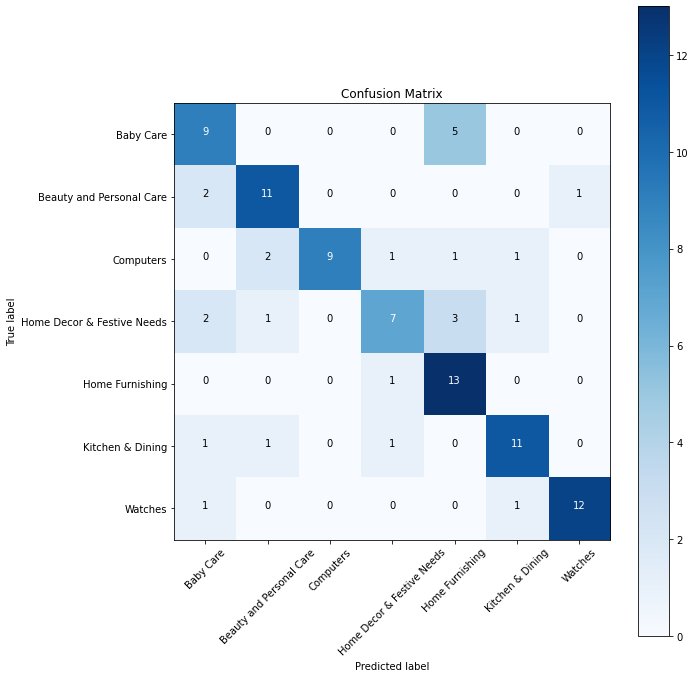

Normalized confusion matrix


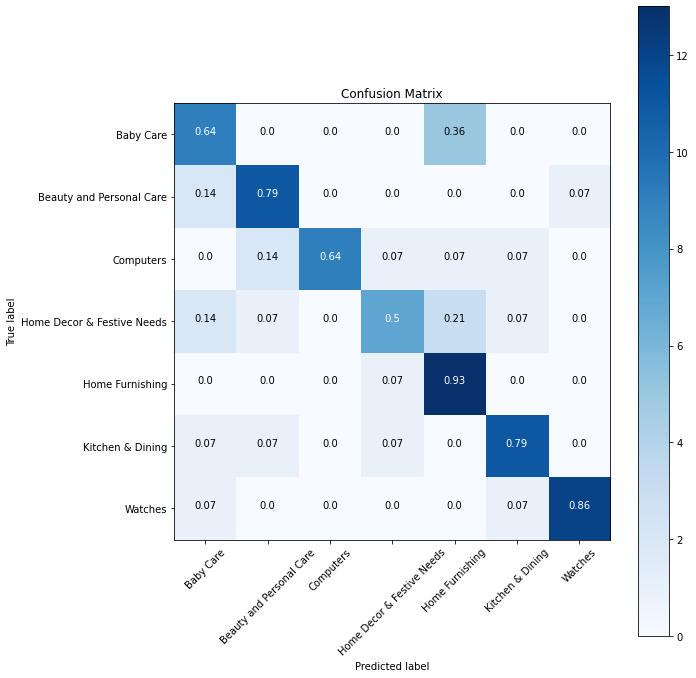

In [142]:
# Get VGG-16 Model with lastFourTrainable=True
vgg_model_b = getVGG16Model(lastFourTrainable=True)
# Train VGG-16 Model and get Confusion Matrix
vgg_model_b = trainModelAndGetConfusionMatrix(vgg_model_b)
vgg_model_b.save_weights('model_vgg_trainable_denoise.h5')

## Transfer Learning with efficientnetB0 for images feature extraction

In [143]:
# function import
from tensorflow.keras.applications import EfficientNetB0

In [144]:
# feature extraction
model = EfficientNetB0(include_top=False, weights='imagenet', pooling='avg')

In [145]:
# download images
features_list = []
images_list = []
from os import listdir

images = "Flipkart/images_denoising/"
list_photos_b0 = [file for file in listdir(images) if '.jpg' in file and not '(1)' in file]



for im in list_photos_b0:
    im_arr = cv2.imread(images + im)
    img = cv2.resize(im_arr, (224, 224)).reshape(-1, 224, 224, 3)
    im_feat = model(img).numpy()[0]
    features_list.append((im, im_feat))

In [146]:
# Get categorie labels
list_categories = [data2[data2['image']==photo].product_category.item() for photo in list_photos_b0]
list_cate_code = [data2[data2['image']==photo].product_category_code.item() for photo in list_photos_b0]

In [147]:
features = [feat[1] for feat in features_list]
tsne = manifold.TSNE(n_components=2, init='pca', random_state=0)
X_tsne = tsne.fit_transform(np.stack(features))

/Users/yixuanzhao/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/Users/yixuanzhao/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


(1050, 3)


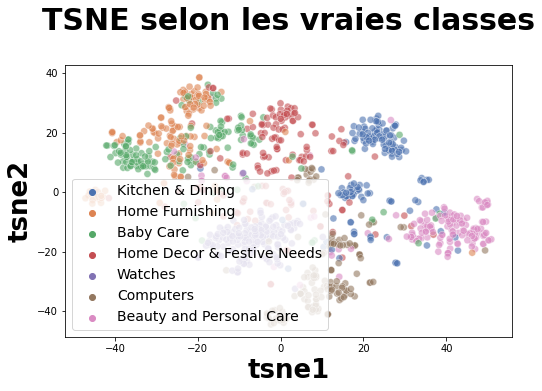

In [148]:
df_tsne = pd.DataFrame(X_tsne[:,0:2], columns=['tsne1', 'tsne2'])
df_tsne["class"] = list_categories
print(df_tsne.shape)
plt.figure(figsize=(8,5))
sns.scatterplot(
    x="tsne1", y="tsne2", hue="class", data=df_tsne, legend="brief",
    palette="deep", s=50, alpha=0.6)

plt.title('TSNE selon les vraies classes', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 14}) 

plt.show()

In [149]:
#  K-means clustering
from sklearn import cluster, metrics

cls = cluster.KMeans(n_clusters=7, random_state=42)
cls.fit(X_tsne)

df_tsne["cluster"] = cls.labels_
print(df_tsne.shape)

(1050, 4)


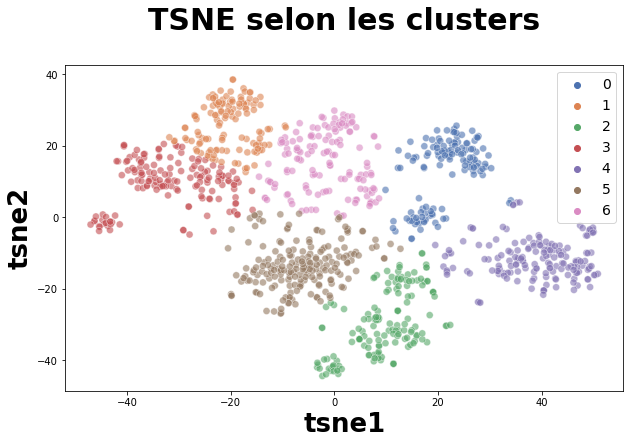

ARI :  0.48686460991988656


In [150]:
# K-means clustering and ARI
plt.figure(figsize=(10,6))
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="cluster",
    palette="deep", s=50, alpha=0.6,
    data=df_tsne,
    legend="brief")

plt.title('TSNE selon les clusters', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 14}) 

plt.show()

labels = list_cate_code
print("ARI : ", metrics.adjusted_rand_score(labels, cls.labels_))
